In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import model_from_json
from sklearn.metrics import roc_auc_score

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
mnist.load_data

<function keras.src.datasets.mnist.load_data(path='mnist.npz')>

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train[1:].max()

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 255)

In [5]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

y_train_one_hot.shape, y_test_one_hot.shape

((60000, 10), (10000, 10))

In [6]:
X_train_tensor = X_train.astype('float32') / 255.0
X_test_tensor = X_test.astype('float32') / 255.0

X_train_tensor.shape, X_train_tensor[1:].max()

((60000, 28, 28), 1.0)

In [7]:
image_size = X_train.shape[1]
INPUT_SIZE = image_size * image_size

X_train_tensor_reshaped = np.reshape(X_train, [-1, INPUT_SIZE])
X_test_tensor_reshaped = np.reshape(X_test, [-1, INPUT_SIZE])

X_train_tensor_reshaped.shape, X_test_tensor_reshaped.shape

((60000, 784), (10000, 784))

In [8]:
BATCH_SIZE=128
HIDDEN_UNITS=256
DROPOUT=0.45
NUM_LABELS = len(np.unique(y_train))

NUM_LABELS

10

In [9]:
x_in = Input(shape=(INPUT_SIZE,))
x1 = Dense(units=HIDDEN_UNITS, activation='relu')(x_in)
d1 = Dropout(DROPOUT)(x1)
x2 = Dense(units=HIDDEN_UNITS, activation='relu')(d1)
d2 = Dropout(DROPOUT)(x2)
x_out = Dense(units=NUM_LABELS, activation='softmax')(d2)

model = Model(inputs=[x_in], outputs=[x_out])

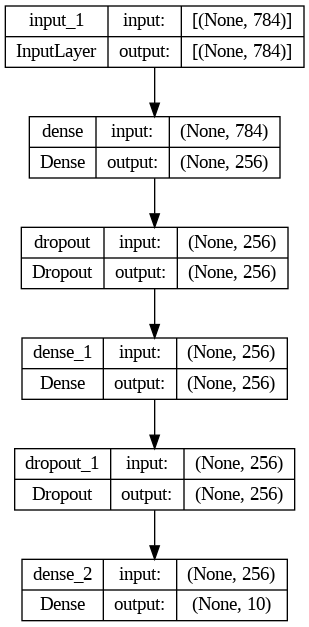

In [10]:
plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 269322 (1.03

In [12]:
EarlyStopping

keras.src.callbacks.EarlyStopping

In [13]:
earlystop = EarlyStopping(monitor='loss', patience=10)

In [14]:
ModelCheckpoint

keras.src.callbacks.ModelCheckpoint

In [15]:
roc_auc_score

<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>

In [16]:
!mkdir model_output
!ls /content/*

mkdir: cannot create directory ‘model_output’: File exists
/content/model.png

/content/model_output:
weights-01-0.270999.h5	weights-03.h5		weights-07.h5  weights-12.h5  weights-17.h5
weights-01.h5		weights-04-0.258953.h5	weights-08.h5  weights-13.h5  weights-18.h5
weights-02-0.271904.h5	weights-04.h5		weights-09.h5  weights-14.h5  weights-19.h5
weights-02.h5		weights-05.h5		weights-10.h5  weights-15.h5  weights-20.h5
weights-03-0.263734.h5	weights-06.h5		weights-11.h5  weights-16.h5  weights.h5

/content/sample_data:
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [17]:
filepath='/content/model_output' + '/weights-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=False,
                             save_freq='epoch')

In [18]:
class my_custom_callback(Callback):
  def __init__(self, features, target):
    self.test_data = (features, target)
    self.auc = []

  def on_epoch_end(self, epoch, logs=None):
    y_pred = self.model.predict(self.test_data[0])
    auc = roc_auc_score(self.test_data[1], y_pred)
    print(' \n auc score for val set :', auc, '\n')
    self.auc.append((epoch, auc))
    return

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [20]:
mycallback=my_custom_callback(X_test_tensor_reshaped, y_test_one_hot)

In [23]:
model.fit(X_train_tensor_reshaped, y_train_one_hot, epochs=20, batch_size=BATCH_SIZE, verbose=1,
          validation_data=(X_test_tensor_reshaped, y_test_one_hot), callbacks=[mycallback, earlystop, checkpoint])

Epoch 1/20
313/313 [==============================] - 1s 2ms/step
 
 auc score for val set : 0.9974690307259296 

469/469 [==============================] - 5s 11ms/step - loss: 0.2819 - acc: 0.9275 - val_loss: 0.1892 - val_acc: 0.9524
Epoch 2/20
313/313 [==============================] - 1s 2ms/step
 
 auc score for val set : 0.9972765145173312 

469/469 [==============================] - 8s 17ms/step - loss: 0.2774 - acc: 0.9288 - val_loss: 0.1878 - val_acc: 0.9545
Epoch 3/20
313/313 [==============================] - 1s 3ms/step
 
 auc score for val set : 0.9978857224405326 

469/469 [==============================] - 6s 13ms/step - loss: 0.2736 - acc: 0.9311 - val_loss: 0.1705 - val_acc: 0.9567
Epoch 4/20
313/313 [==============================] - 1s 3ms/step
 
 auc score for val set : 0.9977306932157184 

469/469 [==============================] - 10s 22ms/step - loss: 0.2696 - acc: 0.9328 - val_loss: 0.1763 - val_acc: 0.9563
Epoch 5/20
313/313 [==============================] - 1

In [25]:
model_json = model.to_json()

with open('model.json', 'w') as json_file:
  json_file.write(model_json)

In [26]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [27]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 269322 (1.03

In [28]:
loaded_model.load_weights('/content/model_output/weights-15.h5')


In [30]:
p = loaded_model.predict(X_test_tensor_reshaped)
labels_test_predicted = np.argmax(p, axis=1)
labels_test_predicted

313/313 [==============================] - 1s 3ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [31]:
pd.crosstab(np.argmax(y_test_one_hot, 1), np.argmax(p, 1))

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,966,0,0,0,0,1,5,1,6,1
1,0,1120,2,0,0,1,3,0,9,0
2,5,1,986,7,3,0,3,7,18,2
3,0,1,12,960,0,10,2,9,11,5
4,1,0,2,0,939,0,8,3,6,23
5,3,0,0,24,2,822,17,0,20,4
6,8,2,0,0,2,3,934,0,9,0
7,3,3,16,2,1,0,0,980,10,13
8,6,0,2,5,8,8,12,4,926,3
